In [1]:
import numpy as np

from flatland.envs.observations import TreeObsForRailEnv, LocalObsForRailEnv, GlobalObsForRailEnv
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.utils.rendertools import RenderTool

## doc string of the provided observation classes

In [2]:
print(TreeObsForRailEnv.__doc__)


    TreeObsForRailEnv object.

    This object returns observation vectors for agents in the RailEnv environment.
    The information is local to each agent and exploits the graph structure of the rail
    network to simplify the representation of the state of the environment for each agent.

    For details about the features in the tree observation see the get() function.
    


In [3]:
print(LocalObsForRailEnv.__doc__)


    !!!!!!WARNING!!! THIS IS DEPRACTED AND NOT UPDATED TO FLATLAND 2.0!!!!!
    Gives a local observation of the rail environment around the agent.
    The observation is composed of the following elements:

        - transition map array of the local environment around the given agent,           with dimensions (view_height,2*view_width+1, 16),           assuming 16 bits encoding of transitions.

        - Two 2D arrays (view_height,2*view_width+1, 2) containing respectively,         if they are in the agent's vision range, its target position, the positions of the other targets.

        - A 2D array (view_height,2*view_width+1, 4) containing the one hot encoding of directions           of the other agents at their position coordinates, if they are in the agent's vision range.

        - A 4 elements array with one hot encoding of the direction.

    Use the parameters view_width and view_height to define the rectangular view of the agent.
    The center parameters moves the agent a

 <font color = brown>Note that the maintainers of the flatland env. have [posted](https://flatland.aicrowd.com/getting-started/env/observations.html#local-grid-observation) the following cautianary note about the LocalObsForRailEnv() class: </font>
 
 ```The local grid observation has shown limited experimental results and is considered deprecated. We keep it for historical purpose, and because it may be useful when combined with other observations. Be aware that its implementation is not currently supported.```

In [4]:
print(GlobalObsForRailEnv.__doc__)


    Gives a global observation of the entire rail environment.
    The observation is composed of the following elements:

        - transition map array with dimensions (env.height, env.width, 16),          assuming 16 bits encoding of transitions.

        - obs_agents_state: A 3D array (map_height, map_width, 5) with
            - first channel containing the agents position and direction
            - second channel containing the other agents positions and direction
            - third channel containing agent/other agent malfunctions
            - fourth channel containing agent/other agent fractional speeds
            - fifth channel containing number of other agents ready to depart

        - obs_targets: Two 2D arrays (map_height, map_width, 2) containing respectively the position of the given agent         target and the positions of the other agents targets (flag only, no counter!).
    


## Setting up the environment to return Global observations

In [5]:
np.random.seed(1)

# Use the complex_rail_generator to generate feasible network configurations with corresponding tasks
# Training on simple small tasks is the best way to get familiar with the environment
N_agents = 3
width = 15
height = 15
env_seed = 1

TreeObservation = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())
LocalGridObs = LocalObsForRailEnv(view_height=10, view_width=2, center=2)
GlobalObs = GlobalObsForRailEnv()
rail_generator = complex_rail_generator(nr_start_goal=10, nr_extra=2, min_dist=8, max_dist=99999, seed=env_seed)
env = RailEnv(width = width, height=height,
              rail_generator= rail_generator,
              schedule_generator=complex_schedule_generator(), 
              number_of_agents=N_agents, 
              obs_builder_object=GlobalObs)
env.reset()

env_renderer = RenderTool(env)

### Getting an observation

In [6]:
obs, info = env.reset()

In [7]:
# obs is dictionary whose keys correspond to the agents with the values be the observation of that agent
# Thus the observations for agent i are contained in obs[i]
print('obs has type: {}'.format(type(obs)))
print('number of keys in obs are: {}'.format(obs.__len__()))
print('obs keys are: {}'.format(obs.keys()))
print('The values of obs are have type: {}'.format(type(obs[0])))
print('Each global observation tuple contains {} ' \
      'arrays of shape: {}, {} and {} respectively'.format(obs[0].__len__(), 
                                                           obs[0][0].shape,
                                                           obs[0][1].shape, 
                                                           obs[0][2].shape))

obs has type: <class 'dict'>
number of keys in obs are: 3
obs keys are: dict_keys([0, 1, 2])
The values of obs are have type: <class 'tuple'>
Each global observation tuple contains 3 arrays of shape: (15, 15, 16), (15, 15, 5) and (15, 15, 2) respectively


In [8]:
env_renderer.render_env(show=True, show_observations=True, show_predictions=False)

open_window - pyglet


/home/prarit/anaconda3/envs/flatland-rl/lib/python3.6/site-packages/flatland/utils/rendertools.py:396: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


In [9]:
# to close the pyglet window opened by env_renderer
# uncomment and run the following command
# env_renderer.close_window()

#### Transition Maps

A detailed descritption of the transition maps can be obtained form [here](https://flatlandrl-docs.aicrowd.com/03_tutorials.html#transitions-maps)

In [10]:
import matplotlib.pyplot as plt

Following is a static image of the grid generated by our environment.

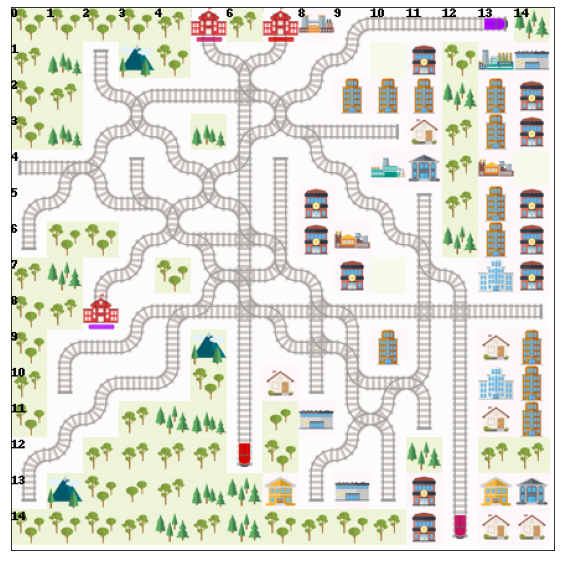

In [11]:
plt.figure(figsize = (10,10))
plt.imshow(env_renderer.get_image())
plt.xticks([])
plt.yticks([])
plt.show()

In [12]:
transition_map = obs[0][0]

The (i,j)-element of the transition map gives us the possible transitions in the (i,j)-cell of the grid. These are one-hot-encoded vectors, ```where the bits have to following meaning: NN NE NS NW EN EE ES EW SN SE SS SW WN WE WS WW ``` Here ```NN``` implies a train moving in the northwards direction can continue north when it enters the cell. Similarly, ```ES``` implies that a train moving in eastwards direction can move southwards when it enters the cell. More generally, ```AB``` implies that a train moving in direction A can move in direction B when it enters the cell. ```For example the binary code 1000 0000 0010 0000, represents a straigt where an agent facing north can transition north and an agent facing south can transition south and no other transitions are possible.``` For more details on the transitions, look at the doc string of the RailEnvTransitions() class [here](https://gitlab.aicrowd.com/flatland/flatland/blob/master/flatland/core/grid/rail_env_grid.py#L5).


As mentioned in the doc string of the RailEnvTransitions() class, the 16 bits of a transition vector can be grouped into 4 blocks of 4 bits each. Each block corresponds to the direction in which the train is moving before it enters the cell, and the 4 bits of that block then correspond to the direction in which the train can continue to move once it enters the cell. The directions are always mentioned in the clockwise manner i.e. NESW with North pointing towards the top. 

As an explicit example, consider the cell at position (6,11) in the grid as shown in the picture above. We see that 

- if a train moving northwards enters the cell (i.e. the train enters the cell from below) then it can either continue to move north or it can switch directions and move towards west. This implies the first 4 bits of the transition vector must be 1001

- a train moving eastwards can only continue southwards once it enters the cell. This implies the 4 bits in the 2nd block of the transition vector must be 0010

- a train moving southwards can only continue southwards once it enters the cell. This implies the 4 bits in the 3rd block of the transition vector must be 0010

- No trains moving in the westwards direction can enter the cell. This implies that the 4th block of the transition vector must be 0000

Collecting the bits of all the four blocks above we see that the transition vector for the (6,11) cell must be: 1001 0010 0010 0000. This is indeed the case as can be explicitly seen below.  

In [13]:
transition_map[6,11]

array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

#### obs_agents_state

In [14]:
obs_agent_state = obs[0][1]

In [15]:
# first channel contains agent's position and direction
# The matrix contains -1 in all places expect for the element corresponding to the current position of the agent
# The value for the current position of the agent gives its directions: {0: N, 1:E, 2:S, 3:W}
position = np.argwhere(obs_agent_state[:,:,0]!=-1)
direction = obs_agent_state[:,:,0][position[0,0], position[0,1]]
print('current agent\'s position: {}'.format(position))
print('current agent\'s direction: {}'.format(direction))

current agent's position: [[12  6]]
current agent's direction: 2.0


In [16]:
# second channel is supposed to contain other agent's positions and direction
# however this seems merely seems to be a matrix with all elements being -1
obs_agent_state[:,:,1]

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       

In [17]:
other_agents_pos = np.argwhere(obs_agent_state[:,:,1]!=-1)
other_agents_pos

array([], shape=(0, 2), dtype=int64)

In [18]:
# third channel contains agent/other agent malfunctions
obs_agent_state[:,:,2]

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       

In [19]:
# 4th channel contains agent/other agent fractional speeds
obs_agent_state[:,:,3]

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       

In [20]:
# fifth channel contain the number of other agents ready to depart
obs_agent_state[:,:,4]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

#### obs_targets

In [21]:
targets = obs[0][2]

In [22]:
# agent's own target
targets[:,:,0]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [23]:
# targets of all the agents
targets[:,:,1]

array([[0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

## Setting up the environment to return Tree observations

In [24]:
np.random.seed(1)

# Use the complex_rail_generator to generate feasible network configurations with corresponding tasks
# Training on simple small tasks is the best way to get familiar with the environment
N_agents = 3
width = 15
height = 15
env_seed = 1

TreeObservation = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())
LocalGridObs = LocalObsForRailEnv(view_height=10, view_width=2, center=2)
GlobalObs = GlobalObsForRailEnv()
rail_generator = complex_rail_generator(nr_start_goal=10, nr_extra=2, min_dist=8, max_dist=99999, seed=env_seed)
env = RailEnv(width = width, height=height,
              rail_generator= rail_generator,
              schedule_generator=complex_schedule_generator(), 
              number_of_agents=N_agents, 
              obs_builder_object=TreeObservation)
env.reset()

env_renderer = RenderTool(env)

### Getting an observation

In [25]:
obs, info = env.reset()

In [26]:
# obs is dictionary whose keys correspond to the agents with the values be the observation of that agent
# Thus the observations for agent i are contained in obs[i]
print('obs has type: {}'.format(type(obs)))
print('number of keys in obs are: {}'.format(obs.__len__()))
print('obs keys are: {}'.format(obs.keys()))
print('The values of obs are have type: {}'.format(type(obs[0])))

obs has type: <class 'dict'>
number of keys in obs are: 3
obs keys are: dict_keys([0, 1, 2])
The values of obs are have type: <class 'flatland.envs.observations.Node'>


The creators of flatland-rl mention that 
        
 ```It is important to note that the tree observation is always build according to the orientation of the agent at a given node. This means that each node always has 4 branches coming from it in the directions Left, Forward, Right and Backward. ```

In [27]:
env_renderer.render_env(show=True, show_observations=True, show_predictions=False)

open_window - pyglet


In [28]:
# to close the pyglet window opened by env_renderer
# uncomment and run the following command
# env_renderer.close_window()

In [29]:
import matplotlib.pyplot as plt

Following is a static image of the grid generated by our environment.

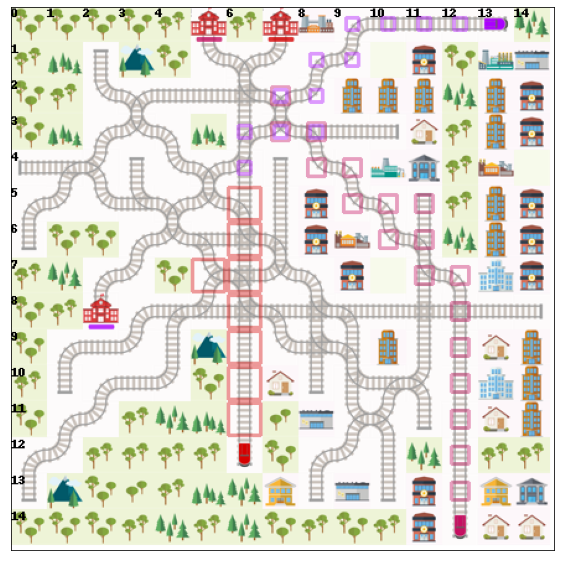

In [30]:
plt.figure(figsize = (10,10))
plt.imshow(env_renderer.get_image())
plt.xticks([])
plt.yticks([])
plt.show()

In [31]:
obs[0].childs

{'L': -inf,
 'F': Node(dist_own_target_encountered=inf, dist_other_target_encountered=inf, dist_other_agent_encountered=inf, dist_potential_conflict=inf, dist_unusable_switch=4, dist_to_next_branch=5, dist_min_to_target=8.0, num_agents_same_direction=0, num_agents_opposite_direction=0, num_agents_malfunctioning=0, speed_min_fractional=1.0, num_agents_ready_to_depart=0, childs={'L': Node(dist_own_target_encountered=inf, dist_other_target_encountered=inf, dist_other_agent_encountered=inf, dist_potential_conflict=inf, dist_unusable_switch=inf, dist_to_next_branch=6, dist_min_to_target=11.0, num_agents_same_direction=0, num_agents_opposite_direction=0, num_agents_malfunctioning=0, speed_min_fractional=1.0, num_agents_ready_to_depart=0, childs={}), 'F': Node(dist_own_target_encountered=inf, dist_other_target_encountered=inf, dist_other_agent_encountered=inf, dist_potential_conflict=inf, dist_unusable_switch=6, dist_to_next_branch=7, dist_min_to_target=6.0, num_agents_same_direction=0, num_a

In [32]:
dir(obs[0])[-13:]

['dist_min_to_target',
 'dist_other_agent_encountered',
 'dist_other_target_encountered',
 'dist_own_target_encountered',
 'dist_potential_conflict',
 'dist_to_next_branch',
 'dist_unusable_switch',
 'index',
 'num_agents_malfunctioning',
 'num_agents_opposite_direction',
 'num_agents_ready_to_depart',
 'num_agents_same_direction',
 'speed_min_fractional']

In [33]:
for attr in dir(obs[0])[-13:]:
    print(attr+': {}'.format(obs[0].__getattribute__(attr)))

dist_min_to_target: 13.0
dist_other_agent_encountered: 0
dist_other_target_encountered: 0
dist_own_target_encountered: 0
dist_potential_conflict: 0
dist_to_next_branch: 0
dist_unusable_switch: 0
index: <built-in method index of Node object at 0x7fc50e065a48>
num_agents_malfunctioning: 0
num_agents_opposite_direction: 0
num_agents_ready_to_depart: 0
num_agents_same_direction: 0
speed_min_fractional: 1.0
